In [1]:
%matplotlib inline

import seaborn as sns

cmap = sns.light_palette('azure', input='xkcd')

In [2]:
import pandas as pd

train_meta = pd.read_csv('CNIChallenge/train/SupportingInfo/phenotypic_training.csv')
test_meta = pd.read_csv('CNIChallenge/test/SupportingInfo/phenotypic_validation.csv')

In [3]:
import math
import numpy as np
from scipy.stats import pearsonr
from sklearn.utils.graph_shortest_path import graph_shortest_path
from sklearn.preprocessing import normalize
from ot import emd2

def correlation_matrix(mt):
    n = len(mt)
    res = np.array([[pearsonr(p, q)[0] for q in mt] for p in mt])
    for i in range(n):
        res[i, i] = 0
    return res

def floyd(mt):
    return graph_shortest_path(mt, False, 'auto')

def get_curvature(mt, threshold=0):
    n = len(mt)
    ab = np.abs(mt)
    hop = ab > threshold
    dist = floyd(hop)
    piles = normalize(hop * ab, 'l1')
    res = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if dist[i, j] > 0:
                res[i, j] = 1 - emd2(piles[i], piles[j], dist) / dist[i, j]
    return res

def process_file(file):
    table = pd.read_csv(file, header=None).values
    print('Read {}'.format(file))
    corr = correlation_matrix(table)
    print('Correlated {}'.format(file))
    curv = get_curvature(corr)
    print('Done {}'.format(file))
    return curv

In [4]:
import os
from concurrent.futures import ThreadPoolExecutor

def load_curvature(Dir):
    file = Dir + '/curvature.npy'
    try:
        return np.load(file)
    except:
        subdirs = sorted(os.listdir(Dir))
        files = [ '{}/{}/timeseries_cc200.csv'.format(Dir, subdir) for subdir in subdirs ]
        with ThreadPoolExecutor() as executor:
            futures = [ executor.submit(process_file, file) for file in files ]
            curvature = np.array([ future.result() for future in futures ])
        np.save(file, curvature)
        return curvature

In [5]:
train = load_curvature('CNIChallenge/train/Training')
test = load_curvature('CNIChallenge/test/Validation')

In [6]:
train_meta.columns

Index(['Subj', 'Sex', 'Age', 'DX', 'WISC_FSIQ', 'Edinburgh_Handedness'], dtype='object')

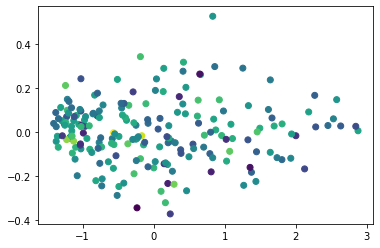

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

x = PCA(n_components=2).fit_transform(train.mean(1))
c = train_meta['WISC_FSIQ']
plt.scatter(x[:,0], x[:,1], c=c)
plt.show()

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix

def show_accuracy(y_test, y_pred):
    print('Точность: ', round(accuracy_score(y_test, y_pred), 3))
    conf_mt = confusion_matrix(y_test, y_pred)
    labels = ['CTL', 'PNT']
    ax = plt.subplot()
    sns.heatmap(conf_mt, annot=True, ax=ax, cmap=cmap)
    ax.set_xlabel('Предсказание')
    ax.set_ylabel('На самом деле')
    ax.set_title('Ошибки')
    ax.xaxis.set_ticklabels(labels) 
    ax.yaxis.set_ticklabels(labels, rotation=360)
    plt.show()

def predict(prepX, prepY, Predictor):
    X = prepX(train)
    X_tr = X(train)
    y_tr = prepY(train_meta)
    X_ts = X(test)
    y_ts = prepY(test_meta)
    pred = Predictor().fit(X_tr, y_tr).predict(X_ts)
    return (y_ts, pred)

Точность:  0.65


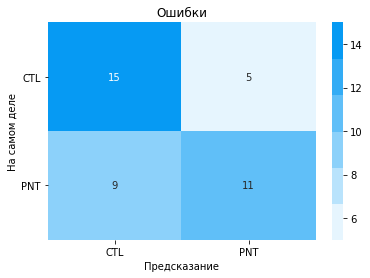

In [9]:
from sklearn.linear_model import LogisticRegression

def prep(src):
    f = PCA(n_components=1).fit(src.mean(1)).transform
    return lambda x: f(x.mean(1))

def y(src):
    return src['DX'] == 'ADHD'

show_accuracy(*predict(prep, y, LogisticRegression))

Точность:  0.725


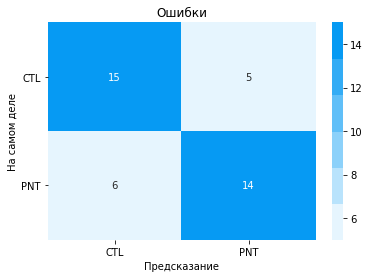

In [10]:
from sklearn.preprocessing import StandardScaler

def histo(x):
    return np.array([np.histogram(y, bins=100, range=(0.5, 1))[0] for y in x])

def prep(src):
    scale = StandardScaler().fit(histo(src)).transform
    return lambda x: scale(histo(x))

def y(src):
    return src['DX'] == 'ADHD'

def LogReg():
    return LogisticRegression(max_iter=1000)

show_accuracy(*predict(prep, y, LogReg))